In [1]:
import pandas as pd
import os, sys
import numpy as np

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../..')))

from utils.prediction_utils import *

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

random_seed = 42

In [2]:
base_dir = "/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling"
X, y = get_data("mm", base_dir, sample_rate=1.0)

In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247616 entries, 0 to 1247615
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   n          1247616 non-null  int64  
 1   m          1247616 non-null  int64  
 2   p          1247616 non-null  int64  
 3   gflops     1247616 non-null  float64
 4   dtype_16   1247616 non-null  bool   
 5   dtype_32   1247616 non-null  bool   
 6   dtype_b16  1247616 non-null  bool   
dtypes: bool(3), float64(1), int64(3)
memory usage: 41.6 MB


# Feature Engineering

TODO: could do some more feature engineering on I(small n), etc.

But a reasonable baseline is to simply regress based on dtype!

In [4]:
dtypes = ["32", "16", "b16"]
for dtype in dtypes:
    X[f"{dtype}_gflops"] =   X[f"dtype_{dtype}"] * X["gflops"]

X

,n,m,p,gflops,dtype_16,dtype_32,dtype_b16,32_gflops,16_gflops,b16_gflops
0,16,896,48,0.001376,False,True,False,0.001376,0.000000,0.000000
1,16,208,1536,0.010224,False,False,True,0.000000,0.000000,0.010224
2,16,480,10240,0.157286,False,True,False,0.157286,0.000000,0.000000
3,16,240,18432,0.141558,False,False,True,0.000000,0.000000,0.141558
4,16,208,256,0.001704,False,True,False,0.001704,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
1247611,31744,4096,368,95.697240,False,False,True,0.000000,0.000000,95.697240
1247612,31744,5120,6144,1997.159793,True,False,False,0.000000,1997.159793,0.000000
1247613,31744,160,4096,41.607496,False,False,True,0.000000,0.000000,41.607496
1247614,31744,352,144,3.218080,False,False,True,0.000000,0.000000,3.218080


# Train Test Split

15% val, 15% test, 70% train.

In [5]:
df_train, df_val, df_test = get_train_test_split(X, y)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 873331 entries, 532472 to 121958
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   n           873331 non-null  int64  
 1   m           873331 non-null  int64  
 2   p           873331 non-null  int64  
 3   gflops      873331 non-null  float64
 4   dtype_16    873331 non-null  bool   
 5   dtype_32    873331 non-null  bool   
 6   dtype_b16   873331 non-null  bool   
 7   32_gflops   873331 non-null  float64
 8   16_gflops   873331 non-null  float64
 9   b16_gflops  873331 non-null  float64
 10  time        873331 non-null  float64
dtypes: bool(3), float64(5), int64(3)
memory usage: 62.5 MB


# Fitting

Seems like some pretty systematic bias to me!

In [7]:
features = [f"{dtype}_gflops" for dtype in dtypes]

X_lr, y_lr = df_train[features], df_train["time"]

model = sm.OLS(y_lr, X_lr).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                   time   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          9.531e+08
Date:                Sat, 03 Aug 2024   Prob (F-statistic):                        0.00
Time:                        18:10:34   Log-Likelihood:                     -1.8939e+06
No. Observations:              873331   AIC:                                  3.788e+06
Df Residuals:                  873328   BIC:                                  3.788e+06
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [8]:
X_val_lr, y_val_lr = df_val[features], df_val["time"]

y_pred = model.predict(X_val_lr)

# Calculate MSE and R-squared
mse = mean_squared_error(y_val_lr, y_pred)
r2 = r2_score(y_val_lr, y_pred)

# High MSE + high r2
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 4.4357841875539314
R-squared: 0.9996940545822145


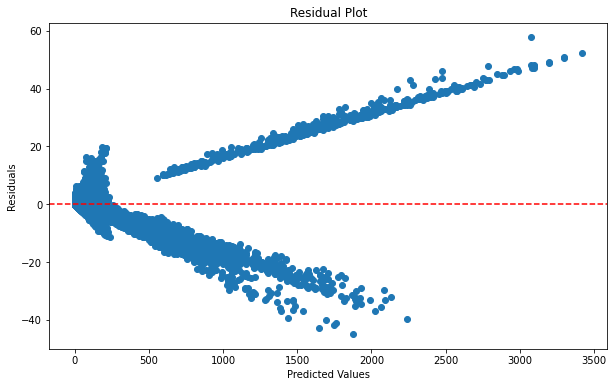

In [10]:
plot_residuals(df_val["time"], y_pred)

# Per dtype

                                 OLS Regression Results                                
Dep. Variable:                   time   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          1.635e+08
Date:                Sat, 03 Aug 2024   Prob (F-statistic):                        0.00
Time:                        18:14:43   Log-Likelihood:                     -2.7307e+05
No. Observations:              291042   AIC:                                  5.461e+05
Df Residuals:                  291041   BIC:                                  5.462e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

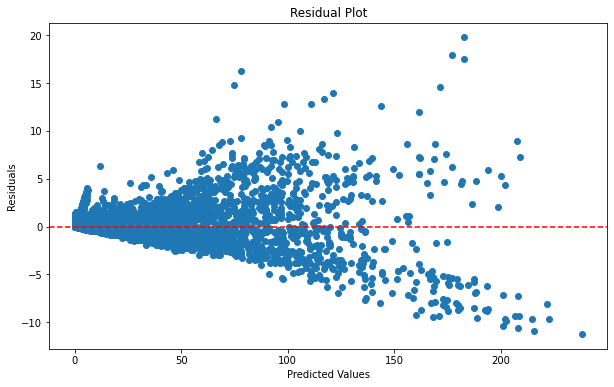

In [20]:
df_16 = df_train.query("dtype_16")
X_lr, y_lr = df_16["16_gflops"], df_16["time"]
model = sm.OLS(y_lr, X_lr).fit()
print(model.summary())


df_16_val = df_val.query("dtype_16")
X_val_lr, y_val_lr = df_16_val["16_gflops"], df_16_val["time"]
y_pred = model.predict(X_val_lr)

# Calculate MSE and R-squared
mse = mean_squared_error(y_val_lr, y_pred)
r2 = r2_score(y_val_lr, y_pred)

# High MSE + high r2
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

plot_residuals(y_val_lr, y_pred)


                                 OLS Regression Results                                
Dep. Variable:                   time   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          1.803e+08
Date:                Sat, 03 Aug 2024   Prob (F-statistic):                        0.00
Time:                        18:15:18   Log-Likelihood:                     -2.4889e+05
No. Observations:              290789   AIC:                                  4.978e+05
Df Residuals:                  290788   BIC:                                  4.978e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

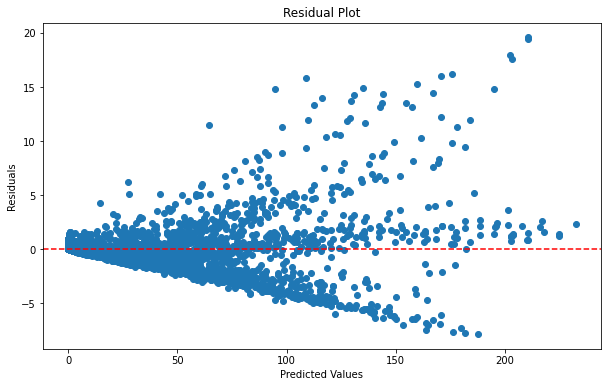

In [22]:
df_16 = df_train.query("dtype_b16")
X_lr, y_lr = df_16["b16_gflops"], df_16["time"]
model = sm.OLS(y_lr, X_lr).fit()
print(model.summary())


df_16_val = df_val.query("dtype_b16")
X_val_lr, y_val_lr = df_16_val["b16_gflops"], df_16_val["time"]
y_pred = model.predict(X_val_lr)

# Calculate MSE and R-squared
mse = mean_squared_error(y_val_lr, y_pred)
r2 = r2_score(y_val_lr, y_pred)

# High MSE + high r2
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

plot_residuals(y_val_lr, y_pred)


                                 OLS Regression Results                                
Dep. Variable:                   time   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          9.978e+08
Date:                Sat, 03 Aug 2024   Prob (F-statistic):                        0.00
Time:                        18:15:34   Log-Likelihood:                     -7.8420e+05
No. Observations:              291500   AIC:                                  1.568e+06
Df Residuals:                  291499   BIC:                                  1.568e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

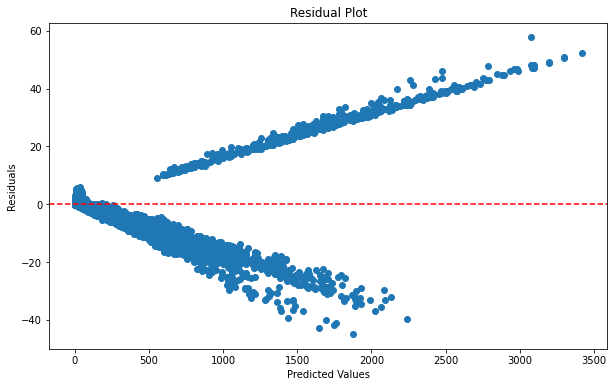

In [23]:
df_16 = df_train.query("dtype_32")
X_lr, y_lr = df_16["32_gflops"], df_16["time"]
model = sm.OLS(y_lr, X_lr).fit()
print(model.summary())


df_16_val = df_val.query("dtype_32")
X_val_lr, y_val_lr = df_16_val["32_gflops"], df_16_val["time"]
y_pred = model.predict(X_val_lr)

# Calculate MSE and R-squared
mse = mean_squared_error(y_val_lr, y_pred)
r2 = r2_score(y_val_lr, y_pred)

# High MSE + high r2
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

plot_residuals(y_val_lr, y_pred)
